In [1]:
#!/usr/bin/env python
r"""
In this example we solve a FOCUS like Stage II coil optimisation problem: the
goal is to find coils that generate a specific target normal field on a given
surface.  In this particular case we consider a vacuum field, so the target is
just zero.

The objective is given by

    J = (1/2) \int |B dot n|^2 ds
        + LENGTH_WEIGHT * (sum CurveLength)
        + DISTANCE_WEIGHT * MininumDistancePenalty(DISTANCE_THRESHOLD)
        + CURVATURE_WEIGHT * CurvaturePenalty(CURVATURE_THRESHOLD)
        + MSC_WEIGHT * MeanSquaredCurvaturePenalty(MSC_THRESHOLD)

if any of the weights are increased, or the thresholds are tightened, the coils
are more regular and better separated, but the target normal field may not be
achieved as well. This example demonstrates the adjustment of weights and
penalties via the use of the `Weight` class.

The target equilibrium is the QA configuration of arXiv:2108.03711.
"""

import os
from pathlib import Path
import numpy as np
import time
from scipy.optimize import minimize
from simsopt._core.optimizable import load
from simsopt.geo.surfacerzfourier import SurfaceRZFourier
from simsopt.objectives.fluxobjective import SquaredFlux
from simsopt.objectives.utilities import QuadraticPenalty
from simsopt.geo.curve import curves_to_vtk, create_equally_spaced_curves
from simsopt.field.biotsavart import BiotSavart
from simsopt.field.coil import Current, coils_via_symmetries
from simsopt.geo.curveobjectives import CurveLength, CurveCurveDistance, \
    MeanSquaredCurvature, LpCurveCurvature, CurveSurfaceDistance, LinkingNumber

# Number of unique coil shapes, i.e. the number of coils per half field period:
# (Since the configuration has nfp = 2, multiply by 4 to get the total number of coils.)
ncoils = 5

# Major radius for the initial circular coils:
R0 = 1.0

# Minor radius for the initial circular coils:
R1 = 0.5

# Number of Fourier modes describing each Cartesian component of each coil:
order = 7

# Weight on the curve lengths in the objective function. We use the `Weight`
# class here to later easily adjust the scalar value and rerun the optimization
# without having to rebuild the objective.
LENGTH_WEIGHT = 0.0156434465

# Threshold and weight for the coil-to-coil distance penalty in the objective function:
CC_THRESHOLD = 0.08
CC_WEIGHT = 156.434465

# Threshold and weight for the coil-to-surface distance penalty in the objective function:
CS_THRESHOLD = 0.12
CS_WEIGHT = 1564.34465

# Threshold and weight for the curvature penalty in the objective function:
CURVATURE_THRESHOLD = 12.
CURVATURE_WEIGHT = 0.000000156434465

# Threshold and weight for the mean squared curvature penalty in the objective function:
MSC_THRESHOLD = 11
MSC_WEIGHT = 1.10e-08

# Number of iterations to perform:
ci = "CI" in os.environ and os.environ['CI'].lower() in ['1', 'true']
MAXITER = 50 if ci else 400

# File for the desired boundary magnetic surface:
filename = 'input.LandremanPaul2021_QH'

# Directory for output
OUT_DIR = "./wiedman/"
os.makedirs(OUT_DIR, exist_ok=True)

#######################################################
# End of input parameters.
#######################################################

# Initialize the boundary magnetic surface:
nphi = 200
ntheta = 32
s = SurfaceRZFourier.from_vmec_input(filename, range="half period", nphi=nphi, ntheta=ntheta)

# Create the initial coils:
base_curves = create_equally_spaced_curves(ncoils, s.nfp, stellsym=True, R0=R0, R1=R1, order=order)
base_currents = [Current(1e5) for i in range(ncoils)]
# Since the target field is zero, one possible solution is just to set all
# currents to 0. To avoid the minimizer finding that solution, we fix one
# of the currents:
#print(base_currents[0].x)
#base_currents[0].fix_all()
#print(base_currents[0].x)

coils = coils_via_symmetries(base_curves, base_currents, s.nfp, True)
bs = BiotSavart(coils)
bs.set_points(s.gamma().reshape((-1, 3)))
print(bs._coils[0]._current.x)
print(bs._coils[1]._current.x)
print(bs._coils[2]._current.x)
print(bs._coils[3]._current.x)

curves = [c.curve for c in coils]
curves_to_vtk(curves, OUT_DIR + "curves_init")
pointData = {"B_N": np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)[:, :, None]}
s.to_vtk(OUT_DIR + "surf_init", extra_data=pointData)

# Define the individual terms objective function:
Jf = SquaredFlux(s, bs)
Jls = [CurveLength(c) for c in base_curves]
Jccdist = CurveCurveDistance(curves, CC_THRESHOLD, num_basecurves=ncoils)
Jcsdist = CurveSurfaceDistance(curves, s, CS_THRESHOLD)
Jcs = [LpCurveCurvature(c, 2, CURVATURE_THRESHOLD) for c in base_curves]
Jmscs = [MeanSquaredCurvature(c) for c in base_curves]
linkNum = LinkingNumber(curves)


# Form the total objective function. To do this, we can exploit the
# fact that Optimizable objects with J() and dJ() functions can be
# multiplied by scalars and added:
JF = Jf \
    + LENGTH_WEIGHT * QuadraticPenalty(sum(Jls), 2.6*ncoils) \
    + CC_WEIGHT * Jccdist \
    + CS_WEIGHT * Jcsdist \
    + CURVATURE_WEIGHT * sum(Jcs) \
    + MSC_WEIGHT * sum(QuadraticPenalty(J, MSC_THRESHOLD) for J in Jmscs) \
    + linkNum
    #+ QuadraticPenalty(linkNum, 0.1)

# We don't have a general interface in SIMSOPT for optimisation problems that
# are not in least-squares form, so we write a little wrapper function that we
# pass directly to scipy.optimize.minimize


def fun(dofs):
    JF.x = dofs
    J = JF.J()
    grad = JF.dJ()
    jf = Jf.J()
    BdotN = np.mean(np.abs(np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)))
    MaxBdotN = np.max(np.abs(np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)))
    mean_AbsB = np.mean(bs.AbsB())
    outstr = f"J={J:.1e}, Jf={jf:.1e}, ⟨B·n⟩={BdotN:.1e}"
    cl_string = ", ".join([f"{J.J():.1f}" for J in Jls])
    kap_string = ", ".join(f"{np.max(c.kappa()):.1f}" for c in base_curves)
    msc_string = ", ".join(f"{J.J():.1f}" for J in Jmscs)
    outstr += f", Len=sum([{cl_string}])={sum(J.J() for J in Jls):.1f}, ϰ=[{kap_string}], ∫ϰ²/L=[{msc_string}]"
    outstr += f", C-C-Sep={Jccdist.shortest_distance():.2f}, C-S-Sep={Jcsdist.shortest_distance():.2f}"
    outstr += f", ║∇J║={np.linalg.norm(grad):.1e}"
    outstr += f", ⟨B·n⟩/|B|={BdotN/mean_AbsB:.1e}"
    outstr += f", (Max B·n)/|B|={MaxBdotN/mean_AbsB:.1e}"
    outstr += f", Link Number = {linkNum.J()}"
    print(outstr)
    return J, grad


print("""
################################################################################
### Run the optimisation #######################################################
################################################################################
""")
dofs = JF.x
res = minimize(fun, dofs, jac=True, method='L-BFGS-B', options={'maxiter': MAXITER, 'maxcor': 300}, tol=1e-15)
curves_to_vtk(curves, OUT_DIR + f"curves_opt_short")
pointData = {"B_N": np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)[:, :, None]}
s.to_vtk(OUT_DIR + "surf_opt_short", extra_data=pointData)


# We now use the result from the optimization as the initial guess for a
# subsequent optimization with reduced penalty for the coil length. This will
# result in slightly longer coils but smaller `B·n` on the surface.
JF = Jf \
    + LENGTH_WEIGHT * QuadraticPenalty(sum(Jls), 2.6*ncoils) \
    + CC_WEIGHT * Jccdist \
    + CS_WEIGHT * Jcsdist \
    + CURVATURE_WEIGHT * sum(Jcs) \
    + MSC_WEIGHT * sum(QuadraticPenalty(J, MSC_THRESHOLD) for J in Jmscs) \

dofs = res.x
print("""################################################################################
### Second Half #########################################################################
################################################################################""")
res = minimize(fun, dofs, jac=True, method='L-BFGS-B', options={'maxiter': MAXITER, 'maxcor': 300}, tol=1e-15)
curves_to_vtk(curves, OUT_DIR + f"curves_opt_long")
pointData = {"B_N": np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)[:, :, None]}
s.to_vtk(OUT_DIR + "surf_opt_long", extra_data=pointData)

timestamp = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())
#This can be rewritten in newer versions of simsopt by saving the BS object as a json file
np.save(OUT_DIR + f'four_field_optimized_{timestamp}', JF.x)




[100000.]
[100000.]
[100000.]
[100000.]

################################################################################
### Run the optimisation #######################################################
################################################################################

J=4.9e-01, Jf=4.3e-01, ⟨B·n⟩=3.2e-01, Len=sum([3.1, 3.1, 3.1, 3.1, 3.1])=15.7, ϰ=[2.0, 2.0, 2.0, 2.0, 2.0], ∫ϰ²/L=[4.0, 4.0, 4.0, 4.0, 4.0], C-C-Sep=0.08, C-S-Sep=0.16, ║∇J║=1.2e+00, ⟨B·n⟩/|B|=3.9e-01, (Max B·n)/|B|=9.1e-01, Link Number = 0
J=5.6e+01, Jf=1.0e-02, ⟨B·n⟩=5.0e-02, Len=sum([3.0, 3.2, 3.6, 3.9, 4.1])=17.8, ϰ=[7.0, 6.2, 5.4, 5.0, 4.7], ∫ϰ²/L=[13.4, 11.1, 8.4, 6.8, 6.4], C-C-Sep=0.01, C-S-Sep=0.14, ║∇J║=4.1e+00, ⟨B·n⟩/|B|=7.8e-02, (Max B·n)/|B|=3.6e-01, Link Number = 56
J=4.8e-01, Jf=4.2e-01, ⟨B·n⟩=3.2e-01, Len=sum([3.1, 3.1, 3.1, 3.1, 3.1])=15.7, ϰ=[2.0, 2.0, 2.0, 2.0, 2.1], ∫ϰ²/L=[4.0, 4.0, 4.0, 4.0, 4.0], C-C-Sep=0.08, C-S-Sep=0.16, ║∇J║=1.2e+00, ⟨B·n⟩/|B|=3.9e-01, (Max B·n)/|B|=9.0e-01, Link 

Text(0.5, 0, '$\\theta$')

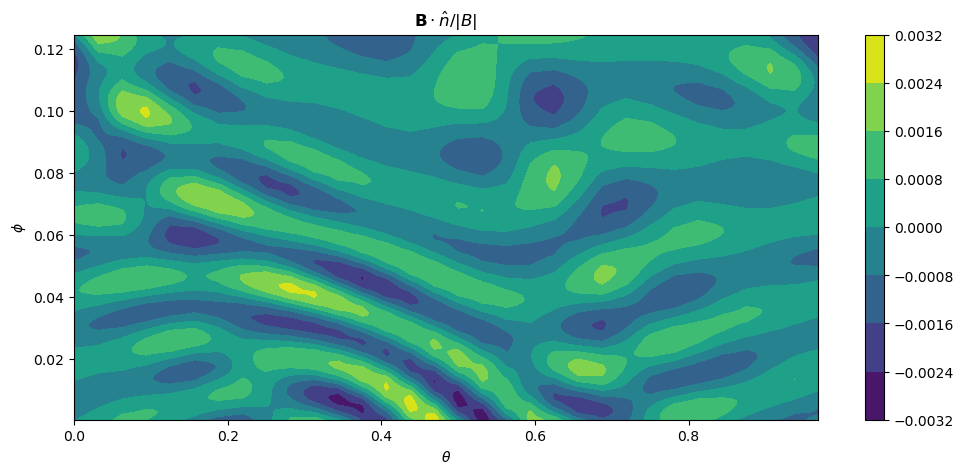

In [3]:
import matplotlib.pyplot as plt 
surf = s
theta = surf.quadpoints_theta
phi = surf.quadpoints_phi
ntheta = theta.size
nphi = phi.size
bs.set_points(surf.gamma().reshape((-1,3)))
Bdotn = np.sum(bs.B().reshape((nphi, ntheta, 3)) * surf.unitnormal(), axis=2)
modB = bs.AbsB().reshape((nphi,ntheta))

fig, ax = plt.subplots(figsize=(12,5))
c = ax.contourf(theta,phi,Bdotn / modB)
plt.colorbar(c)
ax.set_title(r'$\mathbf{B}\cdot\hat{n} / |B|$ ')
ax.set_ylabel(r'$\phi$')
ax.set_xlabel(r'$\theta$')

In [5]:
from simsopt.field import SurfaceClassifier, \
    particles_to_vtk, compute_fieldlines, LevelsetStoppingCriterion, plot_poincare_data


# Run and plot Poincare section
surf = SurfaceRZFourier.from_vmec_input(filename, range="half period", nphi=nphi, ntheta=ntheta)
surf1 = SurfaceRZFourier.from_vmec_input(filename, range="half period", nphi=nphi, ntheta=ntheta)
surf1.extend_via_normal(0.1)
nfp = surf.nfp

Rmaj = surf.major_radius()
r0 = surf.minor_radius()
#sc_fieldline = SurfaceClassifier(surf1, h=0.01, p=3)
nfieldlines = 20
tmax_fl = 2500
degree = 4

def trace_fieldlines(bfield,label):
    # Set up initial conditions - 
    R0 = np.linspace(1.15,1.25, nfieldlines)
    Z0 = np.zeros(nfieldlines)
    phis = [(i/4)*(2*np.pi/nfp) for i in range(4)]
    fieldlines_tys, fieldlines_phi_hits = compute_fieldlines(
        bfield, R0, Z0, tmax=tmax_fl, tol=1e-8,
        phis=phis)#, stopping_criteria=[LevelsetStoppingCriterion(sc_fieldline.dist)])
    plot_poincare_data(fieldlines_phi_hits, phis, 'wiedman/poincare_final', dpi=150,surf=surf,mark_lost=True)
    return fieldlines_phi_hits

hits = trace_fieldlines(bs, 'vmec')

<Figure size 640x480 with 0 Axes>